<a href="https://colab.research.google.com/github/garvkumar68/Quadrabyte/blob/main/ICieee.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import cv2
from google.colab import drive
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
drive.mount('/content/drive')
labels = '/content/drive/MyDrive/kaggle'

Mounted at /content/drive


JUST VISUALS OF THE DATA SET

Closed


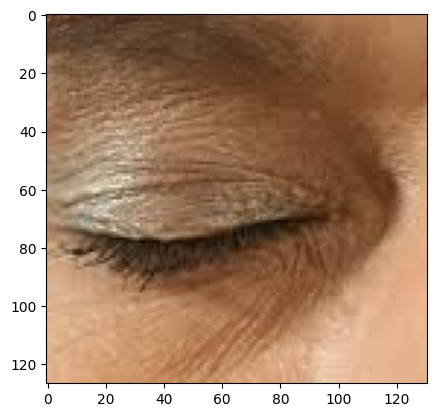

In [ ]:
plt.imshow(plt.imread("/content/drive/MyDrive/kaggle/train/Closed/_10.jpg"))
print('Closed')

Open


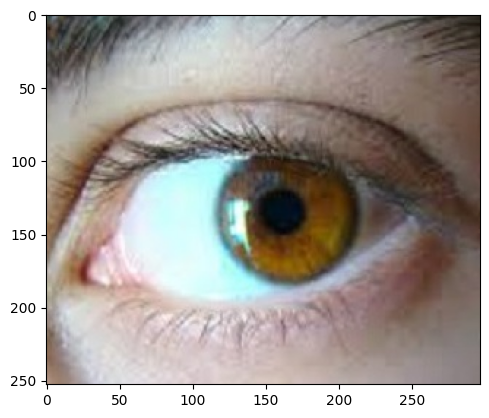

In [ ]:
plt.imshow(plt.imread("/content/drive/MyDrive/kaggle/train/Open/_10.jpg"))
print('Open')

yawn


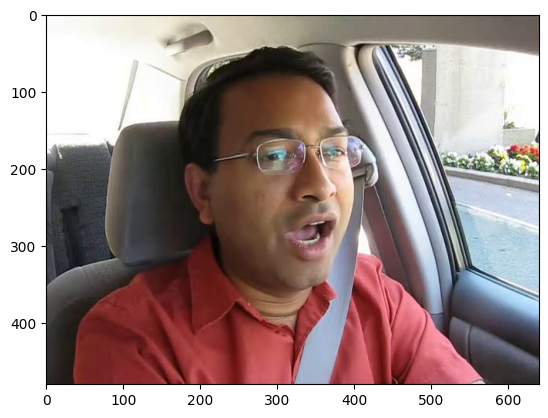

In [ ]:
plt.imshow(plt.imread("/content/drive/MyDrive/kaggle/train/yawn/81.jpg"))
print('yawn')

no_yawn


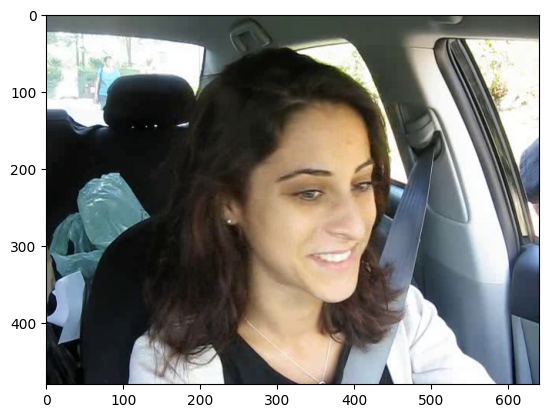

In [ ]:
plt.imshow(plt.imread("/content/drive/MyDrive/kaggle/train/no_yawn/1139.jpg"))
print('no_yawn')

Function to select only face of yawn and no yawn

In [ ]:
def face_for_yawn(direc="/content/drive/MyDrive/kaggle/train", face_cas_path=cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'):
    yaw_no = []
    IMG_SIZE = 145

    categories = ["yawn", "no_yawn"]
    for category in categories:
        path_link = os.path.join(direc, category)
        class_num1 = categories.index(category)
        print(class_num1)
        for image in os.listdir(path_link):
            image_array = cv2.imread(os.path.join(path_link, image), cv2.IMREAD_COLOR)
            face_cascade = cv2.CascadeClassifier(face_cas_path)
            faces = face_cascade.detectMultiScale(image_array, 1.3, 5)
            for (x, y, w, h) in faces:
                img = cv2.rectangle(image_array, (x, y), (x+w, y+h), (0, 255, 0), 2)
                roi_color = img[y:y+h, x:x+w]
                resized_array = cv2.resize(roi_color, (IMG_SIZE, IMG_SIZE))
                yaw_no.append([resized_array, class_num1])
    return yaw_no


yawn_no_yawn = face_for_yawn()

0
1


FUNCTION FOR TAKING ONLY EYE from the jpg file

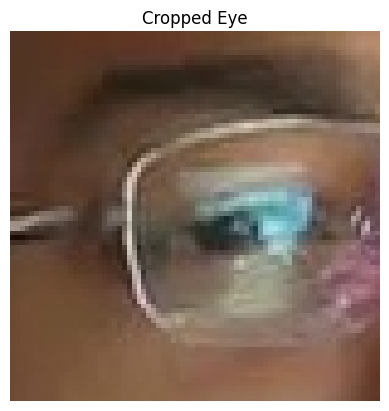

In [ ]:
import cv2
import matplotlib.pyplot as plt

def crop_eye(image_path):
    # Load the image
    image = cv2.imread(image_path)

    if image is None:
        print("Failed to load the image.")
        return None

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Load the pre-trained haarcascade eye classifier
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

    # Detect eyes in the image
    eyes = eye_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Crop the eyes from the image
    if len(eyes) > 0:
        (x, y, w, h) = eyes[0]
        cropped_eye = image[y:y+h, x:x+w]

        # Resize the cropped eye image to fit the input shape of the model
        resized_eye = cv2.resize(cropped_eye, (145, 145))

        # Preprocess the image for the model
        normalized_eye = resized_eye / 255.0
        input_data = normalized_eye.reshape(1, 145, 145, 3)

        # Display the cropped eye image
        plt.imshow(cv2.cvtColor(cropped_eye, cv2.COLOR_BGR2RGB))
        plt.title("Cropped Eye")
        plt.axis('off')
        plt.show()

        return cropped_eye  # Return the cropped eye image

    return None  # Return None if no eyes were detected


# Input image path
image_path = "/content/drive/MyDrive/kaggle/train/yawn/81.jpg"
cropped_eye = crop_eye(image_path)

CHECHKING FOR CLOSED AND OPEN EYES

In [ ]:
def get_data(dir_path, face_cas, eye_cas):
    labels = ['Closed', 'Open']
    IMG_SIZE = 145
    data = []
    for label in labels:
        path = os.path.join(dir_path, label)
        class_num = labels.index(label)
        class_num +=2
        print(class_num)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR)
                resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                data.append([resized_array, class_num])
            except Exception as e:
                print(e)
    return data
data_train=get_data("/content/drive/MyDrive/kaggle/train/","../input/prediction-images/haarcascade_frontalface_default.xml", "../input/prediction-images/haarcascade.xml")

2
3


APPENDING DATA TO ARRAY

In [ ]:
def append_data():
    dir_path = "/content/drive/MyDrive/kaggle/train/"
    face_cas = "../input/prediction-images/haarcascade_frontalface_default.xml"
    eye_cas ="../input/prediction-images/haarcascade.xml"

    yaw_no = face_for_yawn()
    data = get_data(dir_path, face_cas, eye_cas)  # Provide the required arguments

    yaw_no.extend(data)
    return np.array(yaw_no)

new_data = append_data()

X = []
y = []
for feature, label in new_data:
    X.append(feature)
    y.append(label)

0
1
2
3


<ipython-input-5-0f37499b9955>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(yaw_no)


In [ ]:
X = np.array(X)
X = X.reshape(-1, 145, 145, 3)
len(X)

1933

PREPROCESSING

In [ ]:
from sklearn.preprocessing import LabelBinarizer
label_bin = LabelBinarizer()
y = label_bin.fit_transform(y)

In [ ]:
y = np.array(y)
len(y)

1933

In [ ]:
from sklearn.model_selection import train_test_split
seed = 42
test_size = 0.30
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, test_size=test_size)

In [ ]:
len(X_test)

580

DATA AGUMENTATION AND MODEL TRAINING

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
tf.__version__
import keras
keras.__version__

'2.13.1'

In [ ]:
train_generator = ImageDataGenerator(rescale=1/255, zoom_range=0.2, horizontal_flip=True, rotation_range=30)
test_generator = ImageDataGenerator(rescale=1/255)

train_generator = train_generator.flow(np.array(X_train), y_train, shuffle=False)
test_generator = test_generator.flow(np.array(X_test), y_test, shuffle=False)

In [ ]:
model = Sequential()

model.add(Conv2D(256, (3, 3), activation="relu", input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(2, 2))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="softmax"))

model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 143, 143, 256)     7168      
                                                                 
 max_pooling2d (MaxPooling2  (None, 71, 71, 256)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 69, 69, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 34, 34, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 16, 16, 64)        0

In [ ]:
history = model.fit(train_generator, epochs=100, validation_data=test_generator, shuffle=True, validation_steps=len(test_generator))

Epoch 1/100
43/43 [==============================] - 23s 224ms/step - loss: 1.1427 - accuracy: 0.4915 - val_loss: 0.8265 - val_accuracy: 0.6741
Epoch 2/100
43/43 [==============================] - 9s 201ms/step - loss: 0.5451 - accuracy: 0.7724 - val_loss: 0.5035 - val_accuracy: 0.7914
Epoch 3/100
43/43 [==============================] - 9s 209ms/step - loss: 0.4230 - accuracy: 0.8145 - val_loss: 0.4298 - val_accuracy: 0.7983
Epoch 4/100
43/43 [==============================] - 8s 179ms/step - loss: 0.3749 - accuracy: 0.8411 - val_loss: 0.2787 - val_accuracy: 0.8603
Epoch 5/100
43/43 [==============================] - 7s 170ms/step - loss: 0.3663 - accuracy: 0.8404 - val_loss: 0.2865 - val_accuracy: 0.8914
Epoch 6/100
43/43 [==============================] - 9s 212ms/step - loss: 0.3237 - accuracy: 0.8610 - val_loss: 0.2936 - val_accuracy: 0.8741
Epoch 7/100
43/43 [==============================] - 9s 202ms/step - loss: 0.3123 - accuracy: 0.8692 - val_loss: 0.2098 - val_accuracy: 0.929

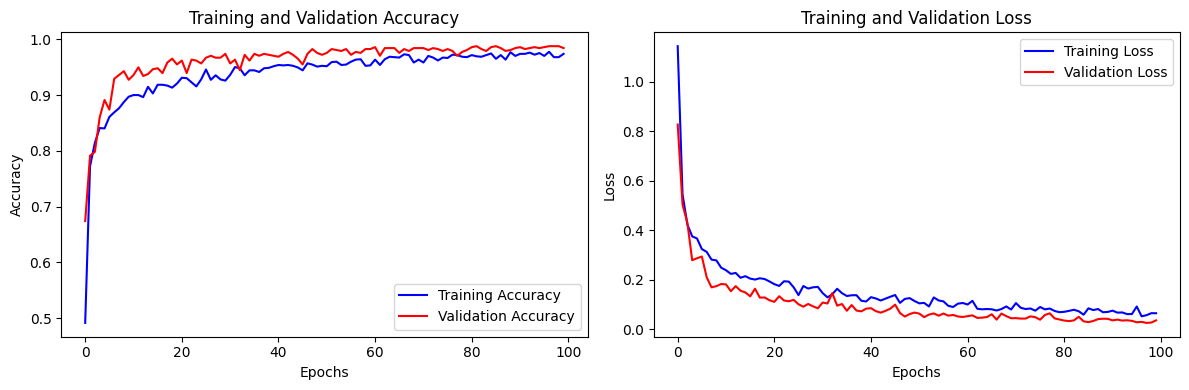

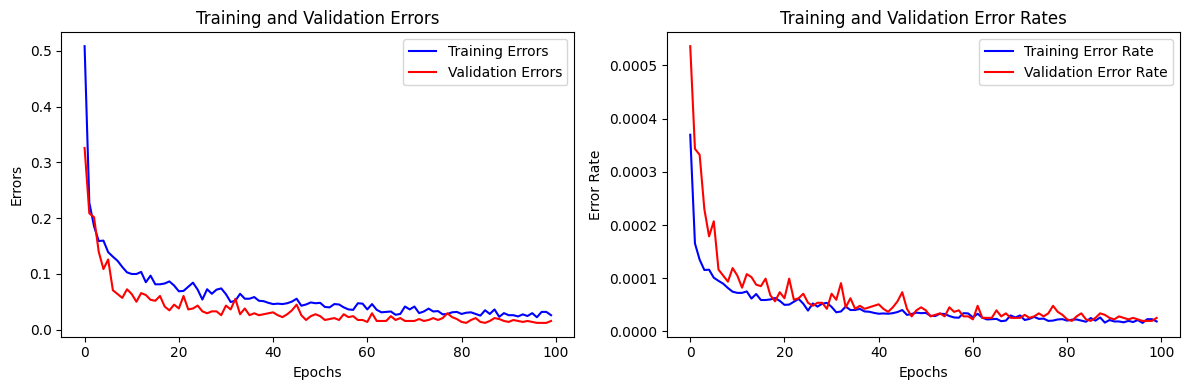

In [ ]:
# Extract training and validation accuracy, loss, and errors
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

# Calculate errors and error rates
train_errors = 1 - np.array(accuracy)
val_errors = 1 - np.array(val_accuracy)
total_train_samples = len(train_generator) * train_generator.batch_size
total_val_samples = len(test_generator) * test_generator.batch_size
train_error_rates = train_errors / total_train_samples
val_error_rates = val_errors / total_val_samples

# Plot training and validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, "b", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, "b", label="Training Loss")
plt.plot(epochs, val_loss, "r", label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")

plt.tight_layout()

# Plot training and validation errors
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_errors, "b", label="Training Errors")
plt.plot(epochs, val_errors, "r", label="Validation Errors")
plt.xlabel("Epochs")
plt.ylabel("Errors")
plt.legend()
plt.title("Training and Validation Errors")

# Plot training and validation error rates
plt.subplot(1, 2, 2)
plt.plot(epochs, train_error_rates, "b", label="Training Error Rate")
plt.plot(epochs, val_error_rates, "r", label="Validation Error Rate")
plt.xlabel("Epochs")
plt.ylabel("Error Rate")
plt.legend()
plt.title("Training and Validation Error Rates")

plt.tight_layout()
plt.show()


In [ ]:
model.save("drowiness_new6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model.save("drowiness_new6.model")

predictions


In [ ]:
prediction = (model.predict(X_test) > 0.5).astype("int")

19/19 [==============================] - 1s 23ms/step


In [ ]:
prediction

array([[0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       ...,
       [0, 0, 1, 0],
       [0, 0, 0, 1],
       [0, 0, 1, 0]])

In [ ]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]

In [ ]:
labels_new = ["yawn", "no_yawn", "Closed", "Open"]
IMG_SIZE = 145
def prepare(filepath, face_cas="../input/prediction-images/haarcascade_frontalface_default.xml"):
    img_array = cv2.imread(filepath, cv2.IMREAD_COLOR)
    img_array = img_array / 255
    resized_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
    return resized_array.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

model = tf.keras.models.load_model("drowiness_new6.h5")

In [ ]:
resized_eye = cv2.resize(cropped_eye, (145, 145))
normalized_eye = resized_eye / 255.0
input_data = normalized_eye.reshape(1, 145, 145, 3)
prediction = model.predict(input_data)
np.argmax(prediction)

1/1 [==============================] - 0s 91ms/step


3

0-yawn, 1-no_yawn, 2-Closed, 3-Open

In [ ]:
prepare("/content/drive/MyDrive/kaggle/train/no_yawn/1068.jpg")
prediction = model.predict([prepare("/content/drive/MyDrive/kaggle/train/no_yawn/1067.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 26ms/step


0

In [ ]:
prediction = model.predict([prepare("/content/drive/MyDrive/kaggle/train/Closed/_97.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 69ms/step


2

In [ ]:
prediction = model.predict([prepare("/content/drive/MyDrive/kaggle/train/Open/_104.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 28ms/step


3

In [ ]:
prediction = model.predict([prepare("/content/drive/MyDrive/kaggle/train/yawn/89.jpg")])
np.argmax(prediction)

1/1 [==============================] - 0s 22ms/step


0

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


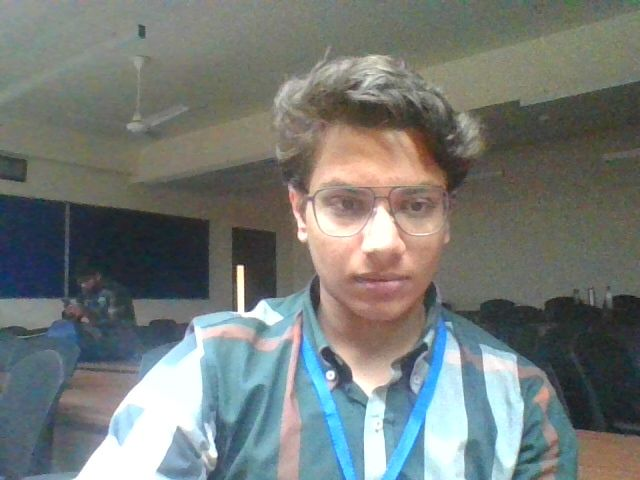

1/1 [==============================] - 0s 19ms/step
3


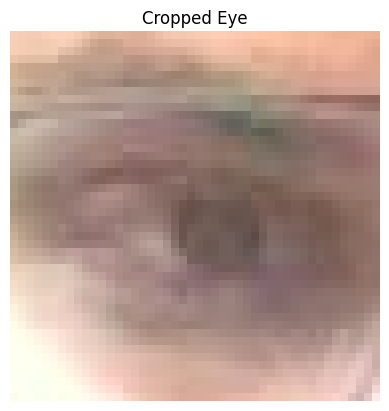

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

prediction = model.predict([prepare("photo.jpg")])
print(np.argmax(prediction))
cropped_eye = crop_eye("photo.jpg")

0-yawn, 1-no_yawn, 2-Eye Closed, 3-Eye Open

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;

    var pendingResolve = null;
    var shutdown = false;

    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }

    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }

    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);

      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);

      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);

      const instruction = document.createElement('div');
      instruction.innerHTML =
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };

      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);

      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();

      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }

      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }

      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;

      return {'create': preShow - preCreate,
              'show': preCapture - preShow,
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)

def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

ESP32 connection through Blynk IOT

In [ ]:
!pip install blynklib
import blynklib
import time


In [ ]:
BLYNK_AUTH_TOKEN = 'J0BpK_Y7m9_tfYmy4hqAfaPN03gcjr7Y'

blynk = blynklib.Blynk(BLYNK_AUTH_TOKEN)

blynk.connect()

In [ ]:
VIRTUAL_PIN_NAME = "V0"
# userdef function to update the virtual pin
def update_virtual_pin(value):
    try:
        blynk.virtual_write(VIRTUAL_PIN, value)
        print(f"Updated virtual pin {VIRTUAL_PIN} with value: {value}")
    except Exception as e:
        print(f"Failed to update virtual pin: {e}")


your_value = 1  # value === prediction detected
update_virtual_pin(your_value)

# Run the Blynk client
while True:
    blynk.run()


REAL TIME FRAME ANALYSIS

In [ ]:
import cv2
import numpy as np
from keras.models import load_model

# Load your pre-trained model
model = load_model("drowiness_new6.h5")  # Replace with the path to your trained model file

# Function to prepare an image for prediction
def prepare_image_for_prediction(image):
    # Preprocess the image (e.g., resize, normalize)
    # Ensure the input dimensions match the model's input shape
    # Return the preprocessed image as a NumPy array
    # Example:
    width, height = 145, 145  # Replace with your model's input dimensions
    prepared_image = cv2.resize(image, (width, height))
    prepared_image = prepared_image / 255.0  # Normalize
    return np.expand_dims(prepared_image, axis=0)

# Start streaming video from webcam
video_stream()
label_html = 'Capturing...'
bbox = ''
count = 0

# Load the face detection cascade classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # Convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # Convert the image to the format expected by your model
    prepared_image = prepare_image_for_prediction(img)

    # Perform prediction using the loaded model
    prediction = model.predict([prepared_image])

    # Get the predicted class or value
    predicted_class = np.argmax(prediction)

    # Display the predicted class or use it as needed
    print("Prediction :", predicted_class)

    # Create transparent overlay for bounding box
    bbox_array = np.zeros([480, 640, 4], dtype=np.uint8)

    # Grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Get face region coordinates
    faces = face_cascade.detectMultiScale(gray)

    # Get face bounding box for overlay
    for (x, y, w, h) in faces:
        bbox_array = cv2.rectangle(bbox_array, (x, y), (x + w, y + h), (255, 0, 0), 2)

    bbox_array[:, :, 3] = (bbox_array.max(axis=2) > 0).astype(int) * 255

    # Convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)

    # Update bbox as needed for overlay
    bbox = bbox_bytes

# Release the webcam and close OpenCV windows
cv2.destroyAllWindows()


<IPython.core.display.Javascript object>

1/1 [==============================] - 0s 79ms/step
Prediction : 3
1/1 [==============================] - 0s 28ms/step
Prediction : 3
1/1 [==============================] - 0s 18ms/step
Prediction : 3
1/1 [==============================] - 0s 20ms/step
Prediction : 3
1/1 [==============================] - 0s 19ms/step
Prediction : 3
1/1 [==============================] - 0s 18ms/step
Prediction : 3
1/1 [==============================] - 0s 27ms/step
Prediction : 3
1/1 [==============================] - 0s 20ms/step
Prediction : 3
1/1 [==============================] - 0s 18ms/step
Prediction : 3
1/1 [==============================] - 0s 21ms/step
Prediction : 3
1/1 [==============================] - 0s 36ms/step
Prediction : 3
1/1 [==============================] - 0s 21ms/step
Prediction : 3


0-yawn; 1-no_yawn; 2-Eye Closed; 3-Eye Open


LIVE PREDICTIONS (VIDEO SOURCE : WEBCAM)

...................

Email notification to closed ones

In [ ]:
import smtplib
from email.mime.text import MIMEText

In [ ]:
your_email = "22bai70298@gmail.com"
your_password = "Garv.70298"
subject = "Your Subject"
sender_email = your_email
recipient_email = "garvkumar059@gmail.com"
message = "This is the message body of your email."
# Create the email message
msg = MIMEText(message)
msg["Subject"] = subject
msg["From"] = sender_email
msg["To"] = recipient_email

# Connect to the SMTP server
try:
    server = smtplib.SMTP("smtp.gmail.com", 587)
    server.starttls()
    server.login(your_email, your_password)

    # Send the email
    server.sendmail(sender_email, recipient_email, msg.as_string())
    print("Email sent successfully!")
except Exception as e:
    print(f"An error occurred: {e}")
finally:
    server.quit()


Car speed reduction to set threshold

In [ ]:
!pip install obd

In [ ]:
import obd
import time

class ElectronicControlUnit:
    def _init_(self, vehicle):
        self.vehicle = vehicle
        self.command = None

    def receive_command(self, command):
        self.command = command

    def execute_command(self):
        if self.command == "slow_down":
            self.vehicle.decelerate()
        else:
            print("Invalid command")

class Vehicle:
    def _init_(self, connection):
        self.speed = 0
        self.connection = connection

    def get_speed(self):
        cmd = obd.commands.SPEED  # OBD command to retrieve vehicle speed
        response = self.connection.query(cmd)  # Query the vehicle for the current speed
        if response.is_null():
            print("No data")
        else:
            self.speed = response.value.to("mph")
            print(f"Current speed: {self.speed} mph")

    def decelerate(self):
        if self.speed >= 5:
            self.speed -= 5
            print(f"Vehicle decelerated. Current speed: {self.speed} km/h")
        else:
            print("Vehicle is already stationary.")

# Establish connection with the vehicle's OBD-II system
connection = obd.OBD()

# Simulation
if counter==6:
    vehicle = Vehicle(connection)
    ecu = ElectronicControlUnit(vehicle)

    vehicle.get_speed()

    ecu.receive_command("slow_down")
    ecu.execute_command()

    vehicle.get_speed()

    ecu.receive_command("slow_down")
    ecu.execute_command()

    vehicle.get_speed()